# Coin Autoencoder

Let's build an Autoencoder with brazilian coin images.

An auto encoder can help us with:
+ Image denoising
+ Dimensionality reduction

Autoencoders are the base of unsupervised learning, because we give unlabelled data and the auto enconder tries to reconstruct that data as next as possible of the original input.

Basically we generate a random distribution and try to reduce the loss as possible to get closer to the original image, like  that:

![](gen_models.svg "Generative Model")

Our neural network will be something like that:
![](autoencoder.png "Autoencoder NN Representation")

## About the project
In this project we'll use `tensorflow`. It can be done well with just numpy but if you're wondering why tensorflow, there are some reasons:
+ More faster C++ math libraries
+ More abstraction
+ Can run in gpu's easily (just install tensorflow-gpu and it will use gpu's automagically)

**Why not keras?**

We can use keras as well, but if you don't have enough practice with `tensorflow` without those keras abstractions it's a good traning.

## Loading data
Let's import our project dependencies and load our data.

The dataset used in this project can be found at [kaggle](https://www.kaggle.com/lgmoneda/br-coins).

We'll use the 960 images from `regression_sample` folder, so extract that file to a folder named `data`, our structure will be like that:

```bash
./
  data/
     ... #our images
  Coin Autoencoder.ipynb #this notebook
```

So, let's code:

In [1]:
# Configuring matplotlib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# importing dependencies and config matplotlib
import glob
import numpy as np
import scipy.misc
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

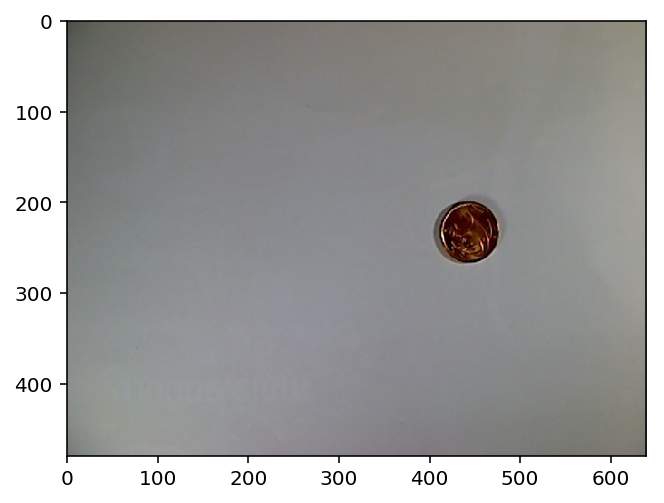

In [3]:
# Display a sample image
plt.imshow(mpimg.imread('data/5_1477188450.jpg'))
plt.show()

In [4]:
### Loading and preprocessing our data

# Function to load images
def pre_load_images():
    images_list = glob.glob('data/*.jpg')
    output = []
    for image in images_list:
        image = mpimg.imread(image)
        image = scipy.misc.imresize(image, (128, 128), interp='nearest')
        image = image.astype(np.float32)
        output.append(image)
    return np.asarray(output, dtype=np.float32)


In [5]:
pre_loaded_images = pre_load_images()
pre_loaded_images.shape

(960, 128, 128, 3)

In [6]:
def normalize_array(x):
    return x / x.max(axis=0)

In [7]:
normalized_images = normalize_array(pre_loaded_images)

## Creating our Neural Network layer functions
Let's create some functions to help building our neural network.

In [8]:
# Returns a convolution layer
def convolution2d(inputs, filters, name, activation):
    return tf.layers.conv2d(inputs, filters, (3,3), padding='same', activation=activation, name=name)

# Returns a max pooling layer
def max_pooling2d(inputs, name):
    return tf.layers.max_pooling2d(inputs, (2,2), (2,2), padding='same', name=name)

# Returns an upsampled layer
def upsample_layer(inputs, shape):
    return tf.image.resize_nearest_neighbor(inputs, shape)

# Returns loss, cost and optimizer functions
def loss_cost_opt(logits, targets):
    decoded = tf.nn.sigmoid(logits, name='decoded')
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits)
    cost = tf.reduce_mean(loss)
    opt = tf.train.AdamOptimizer(0.001).minimize(cost)
    return loss, cost, opt, decoded

## Building our Neural Network

Our Neural Network will be a convolution one. Let's use the functions created above to build it.

The structure will be:

```
Convolution Layer (activation: relu)
Max Pooling Layer
---
Convolution Layer (activation: relu)
Max Pooling Layer
---
Convolution Layer (activation: relu)
Max Pooling Layer
---
Encoded image
---
Unsample Layer
Convolution Layer (activation: relu)
---
Unsample Layer
Convolution Layer (activation: relu)
---
Unsample Layer
Convolution Layer (activation: relu)
---
Decoded image  (activation: None)
```

In [9]:
# Reset variable names
tf.reset_default_graph()

inputs_ = tf.placeholder(tf.float32, (None, 128, 128, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 128, 128, 3), name='targets')

### Encoder
# Layer 1
conv1 = convolution2d(inputs_, 64, 'convol_1', tf.nn.relu)
maxpool1 = max_pooling2d(conv1, 'max_1')

# Layer 2
conv2 = convolution2d(maxpool1, 32, 'convol_2', tf.nn.relu)
maxpool2 = max_pooling2d(conv2, 'max_2')

# Layer 3
conv3 = convolution2d(maxpool2, 32, 'convol_3', tf.nn.relu)
encoded = max_pooling2d(conv3, 'max_3')

### Decoder
# Layer 4
upsample1 = upsample_layer(encoded, (32, 32))
conv4 = convolution2d(upsample1, 32, 'convol_4', tf.nn.relu)

# Layer 5
upsample2 = upsample_layer(conv4, (64, 64))
conv5 = convolution2d(upsample2, 32, 'convol_5', tf.nn.relu)

# Layer 6
upsample3 = upsample_layer(conv5, (128, 128))
conv6 = convolution2d(upsample3, 64, 'convol_6', tf.nn.relu)

# Decoded image
logits = convolution2d(conv6, 3, 'logits', None)

# loss, cost and optmizer
loss, cost, opt, decoded = loss_cost_opt(logits, targets_)

## Training

Let's train our model a little bit to see our results.

In [10]:
# Init tensorflow session
sess = tf.Session()

In [11]:
# Number of traning epochs
epochs = 10
# Initialize our global variables (layers)
sess.run(tf.global_variables_initializer())

# Define our batch size
batch_size = 192

# Split our data in batches
train_batches = np.split(normalized_images, batch_size, axis=0)

# Training
for e in range(epochs):
    for train_batch in train_batches:
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: train_batch,
                                                   targets_: train_batch})
    
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/10... Training loss: 0.6927
Epoch: 1/10... Training loss: 0.6816
Epoch: 1/10... Training loss: 0.6559
Epoch: 1/10... Training loss: 0.6225
Epoch: 1/10... Training loss: 0.5798
Epoch: 1/10... Training loss: 0.6592
Epoch: 1/10... Training loss: 0.6295
Epoch: 1/10... Training loss: 0.5810
Epoch: 1/10... Training loss: 0.6011
Epoch: 1/10... Training loss: 0.6202
Epoch: 1/10... Training loss: 0.6210
Epoch: 1/10... Training loss: 0.6323
Epoch: 1/10... Training loss: 0.6028
Epoch: 1/10... Training loss: 0.6155
Epoch: 1/10... Training loss: 0.5833
Epoch: 1/10... Training loss: 0.5844
Epoch: 1/10... Training loss: 0.6129
Epoch: 1/10... Training loss: 0.5919
Epoch: 1/10... Training loss: 0.6075
Epoch: 1/10... Training loss: 0.5938
Epoch: 1/10... Training loss: 0.6025
Epoch: 1/10... Training loss: 0.6139
Epoch: 1/10... Training loss: 0.6038
Epoch: 1/10... Training loss: 0.6059
Epoch: 1/10... Training loss: 0.6064
Epoch: 1/10... Training loss: 0.6213
Epoch: 1/10... Training loss: 0.6192
E

Epoch: 2/10... Training loss: 0.6039
Epoch: 2/10... Training loss: 0.5634
Epoch: 2/10... Training loss: 0.5847
Epoch: 2/10... Training loss: 0.5996
Epoch: 2/10... Training loss: 0.5652
Epoch: 2/10... Training loss: 0.5913
Epoch: 2/10... Training loss: 0.5677
Epoch: 2/10... Training loss: 0.5440
Epoch: 2/10... Training loss: 0.5704
Epoch: 2/10... Training loss: 0.5691
Epoch: 2/10... Training loss: 0.5895
Epoch: 2/10... Training loss: 0.5921
Epoch: 2/10... Training loss: 0.5459
Epoch: 2/10... Training loss: 0.5336
Epoch: 2/10... Training loss: 0.5805
Epoch: 2/10... Training loss: 0.5862
Epoch: 2/10... Training loss: 0.5777
Epoch: 2/10... Training loss: 0.5815
Epoch: 2/10... Training loss: 0.5730
Epoch: 2/10... Training loss: 0.5548
Epoch: 2/10... Training loss: 0.5788
Epoch: 2/10... Training loss: 0.5289
Epoch: 2/10... Training loss: 0.5631
Epoch: 2/10... Training loss: 0.5931
Epoch: 2/10... Training loss: 0.5756
Epoch: 2/10... Training loss: 0.5916
Epoch: 2/10... Training loss: 0.5998
E

Epoch: 3/10... Training loss: 0.5010
Epoch: 3/10... Training loss: 0.5284
Epoch: 3/10... Training loss: 0.6134
Epoch: 3/10... Training loss: 0.5865
Epoch: 3/10... Training loss: 0.5980
Epoch: 3/10... Training loss: 0.5639
Epoch: 3/10... Training loss: 0.5708
Epoch: 3/10... Training loss: 0.5609
Epoch: 3/10... Training loss: 0.5422
Epoch: 3/10... Training loss: 0.5809
Epoch: 3/10... Training loss: 0.5827
Epoch: 3/10... Training loss: 0.5703
Epoch: 3/10... Training loss: 0.5908
Epoch: 3/10... Training loss: 0.5738
Epoch: 3/10... Training loss: 0.5417
Epoch: 3/10... Training loss: 0.5777
Epoch: 3/10... Training loss: 0.6025
Epoch: 3/10... Training loss: 0.5697
Epoch: 3/10... Training loss: 0.6087
Epoch: 3/10... Training loss: 0.5591
Epoch: 3/10... Training loss: 0.5828
Epoch: 3/10... Training loss: 0.5577
Epoch: 3/10... Training loss: 0.5803
Epoch: 3/10... Training loss: 0.5627
Epoch: 3/10... Training loss: 0.5645
Epoch: 3/10... Training loss: 0.6112
Epoch: 3/10... Training loss: 0.5943
E

Epoch: 4/10... Training loss: 0.5038
Epoch: 4/10... Training loss: 0.5826
Epoch: 4/10... Training loss: 0.5849
Epoch: 4/10... Training loss: 0.5765
Epoch: 4/10... Training loss: 0.5849
Epoch: 4/10... Training loss: 0.5402
Epoch: 4/10... Training loss: 0.5319
Epoch: 4/10... Training loss: 0.5861
Epoch: 4/10... Training loss: 0.5917
Epoch: 4/10... Training loss: 0.5750
Epoch: 4/10... Training loss: 0.5609
Epoch: 4/10... Training loss: 0.5492
Epoch: 4/10... Training loss: 0.5684
Epoch: 4/10... Training loss: 0.5487
Epoch: 4/10... Training loss: 0.5321
Epoch: 4/10... Training loss: 0.6051
Epoch: 4/10... Training loss: 0.5947
Epoch: 4/10... Training loss: 0.5876
Epoch: 4/10... Training loss: 0.6054
Epoch: 4/10... Training loss: 0.5685
Epoch: 4/10... Training loss: 0.5361
Epoch: 4/10... Training loss: 0.5708
Epoch: 4/10... Training loss: 0.5992
Epoch: 4/10... Training loss: 0.5739
Epoch: 4/10... Training loss: 0.5774
Epoch: 4/10... Training loss: 0.5223
Epoch: 4/10... Training loss: 0.5926
E

Epoch: 5/10... Training loss: 0.5954
Epoch: 5/10... Training loss: 0.5161
Epoch: 5/10... Training loss: 0.5844
Epoch: 5/10... Training loss: 0.5895
Epoch: 5/10... Training loss: 0.5419
Epoch: 5/10... Training loss: 0.5403
Epoch: 5/10... Training loss: 0.5751
Epoch: 5/10... Training loss: 0.5657
Epoch: 5/10... Training loss: 0.5791
Epoch: 5/10... Training loss: 0.5294
Epoch: 5/10... Training loss: 0.5468
Epoch: 5/10... Training loss: 0.5725
Epoch: 5/10... Training loss: 0.5734
Epoch: 5/10... Training loss: 0.5471
Epoch: 5/10... Training loss: 0.5520
Epoch: 5/10... Training loss: 0.5338
Epoch: 5/10... Training loss: 0.5850
Epoch: 5/10... Training loss: 0.5401
Epoch: 5/10... Training loss: 0.5947
Epoch: 5/10... Training loss: 0.5570
Epoch: 5/10... Training loss: 0.6033
Epoch: 5/10... Training loss: 0.5630
Epoch: 5/10... Training loss: 0.6128
Epoch: 5/10... Training loss: 0.5805
Epoch: 5/10... Training loss: 0.5168
Epoch: 5/10... Training loss: 0.5742
Epoch: 5/10... Training loss: 0.5356
E

Epoch: 6/10... Training loss: 0.5751
Epoch: 6/10... Training loss: 0.5515
Epoch: 6/10... Training loss: 0.5697
Epoch: 6/10... Training loss: 0.5947
Epoch: 6/10... Training loss: 0.5428
Epoch: 7/10... Training loss: 0.4976
Epoch: 7/10... Training loss: 0.6159
Epoch: 7/10... Training loss: 0.5693
Epoch: 7/10... Training loss: 0.5709
Epoch: 7/10... Training loss: 0.5297
Epoch: 7/10... Training loss: 0.5825
Epoch: 7/10... Training loss: 0.5825
Epoch: 7/10... Training loss: 0.5421
Epoch: 7/10... Training loss: 0.5727
Epoch: 7/10... Training loss: 0.5845
Epoch: 7/10... Training loss: 0.5652
Epoch: 7/10... Training loss: 0.6099
Epoch: 7/10... Training loss: 0.5393
Epoch: 7/10... Training loss: 0.5761
Epoch: 7/10... Training loss: 0.5467
Epoch: 7/10... Training loss: 0.5203
Epoch: 7/10... Training loss: 0.5763
Epoch: 7/10... Training loss: 0.5525
Epoch: 7/10... Training loss: 0.5723
Epoch: 7/10... Training loss: 0.5633
Epoch: 7/10... Training loss: 0.5486
Epoch: 7/10... Training loss: 0.5683
E

Epoch: 8/10... Training loss: 0.5254
Epoch: 8/10... Training loss: 0.5886
Epoch: 8/10... Training loss: 0.5398
Epoch: 8/10... Training loss: 0.5202
Epoch: 8/10... Training loss: 0.5664
Epoch: 8/10... Training loss: 0.5468
Epoch: 8/10... Training loss: 0.5740
Epoch: 8/10... Training loss: 0.5574
Epoch: 8/10... Training loss: 0.5991
Epoch: 8/10... Training loss: 0.5574
Epoch: 8/10... Training loss: 0.5832
Epoch: 8/10... Training loss: 0.5960
Epoch: 8/10... Training loss: 0.5631
Epoch: 8/10... Training loss: 0.5855
Epoch: 8/10... Training loss: 0.5656
Epoch: 8/10... Training loss: 0.5387
Epoch: 8/10... Training loss: 0.5674
Epoch: 8/10... Training loss: 0.5638
Epoch: 8/10... Training loss: 0.5873
Epoch: 8/10... Training loss: 0.5885
Epoch: 8/10... Training loss: 0.5399
Epoch: 8/10... Training loss: 0.5270
Epoch: 8/10... Training loss: 0.5760
Epoch: 8/10... Training loss: 0.5773
Epoch: 8/10... Training loss: 0.5729
Epoch: 8/10... Training loss: 0.5779
Epoch: 8/10... Training loss: 0.5697
E

Epoch: 9/10... Training loss: 0.5690
Epoch: 9/10... Training loss: 0.5585
Epoch: 9/10... Training loss: 0.5888
Epoch: 9/10... Training loss: 0.5627
Epoch: 9/10... Training loss: 0.5497
Epoch: 9/10... Training loss: 0.5154
Epoch: 9/10... Training loss: 0.5671
Epoch: 9/10... Training loss: 0.5662
Epoch: 9/10... Training loss: 0.4975
Epoch: 9/10... Training loss: 0.5258
Epoch: 9/10... Training loss: 0.6123
Epoch: 9/10... Training loss: 0.5851
Epoch: 9/10... Training loss: 0.5961
Epoch: 9/10... Training loss: 0.5613
Epoch: 9/10... Training loss: 0.5690
Epoch: 9/10... Training loss: 0.5590
Epoch: 9/10... Training loss: 0.5395
Epoch: 9/10... Training loss: 0.5793
Epoch: 9/10... Training loss: 0.5812
Epoch: 9/10... Training loss: 0.5686
Epoch: 9/10... Training loss: 0.5893
Epoch: 9/10... Training loss: 0.5704
Epoch: 9/10... Training loss: 0.5380
Epoch: 9/10... Training loss: 0.5757
Epoch: 9/10... Training loss: 0.6007
Epoch: 9/10... Training loss: 0.5677
Epoch: 9/10... Training loss: 0.6078
E

Epoch: 10/10... Training loss: 0.5811
Epoch: 10/10... Training loss: 0.5554
Epoch: 10/10... Training loss: 0.5782
Epoch: 10/10... Training loss: 0.5614
Epoch: 10/10... Training loss: 0.5627
Epoch: 10/10... Training loss: 0.6103
Epoch: 10/10... Training loss: 0.5937
Epoch: 10/10... Training loss: 0.5213
Epoch: 10/10... Training loss: 0.5502
Epoch: 10/10... Training loss: 0.5695
Epoch: 10/10... Training loss: 0.5842
Epoch: 10/10... Training loss: 0.5311
Epoch: 10/10... Training loss: 0.5682
Epoch: 10/10... Training loss: 0.5557
Epoch: 10/10... Training loss: 0.5533
Epoch: 10/10... Training loss: 0.5836
Epoch: 10/10... Training loss: 0.5914
Epoch: 10/10... Training loss: 0.5870
Epoch: 10/10... Training loss: 0.5022
Epoch: 10/10... Training loss: 0.5820
Epoch: 10/10... Training loss: 0.5841
Epoch: 10/10... Training loss: 0.5752
Epoch: 10/10... Training loss: 0.5840
Epoch: 10/10... Training loss: 0.5387
Epoch: 10/10... Training loss: 0.5311
Epoch: 10/10... Training loss: 0.5852
Epoch: 10/10

Let's plot some results for comparing. In the first line we have the original images, and the generated images are on second one.

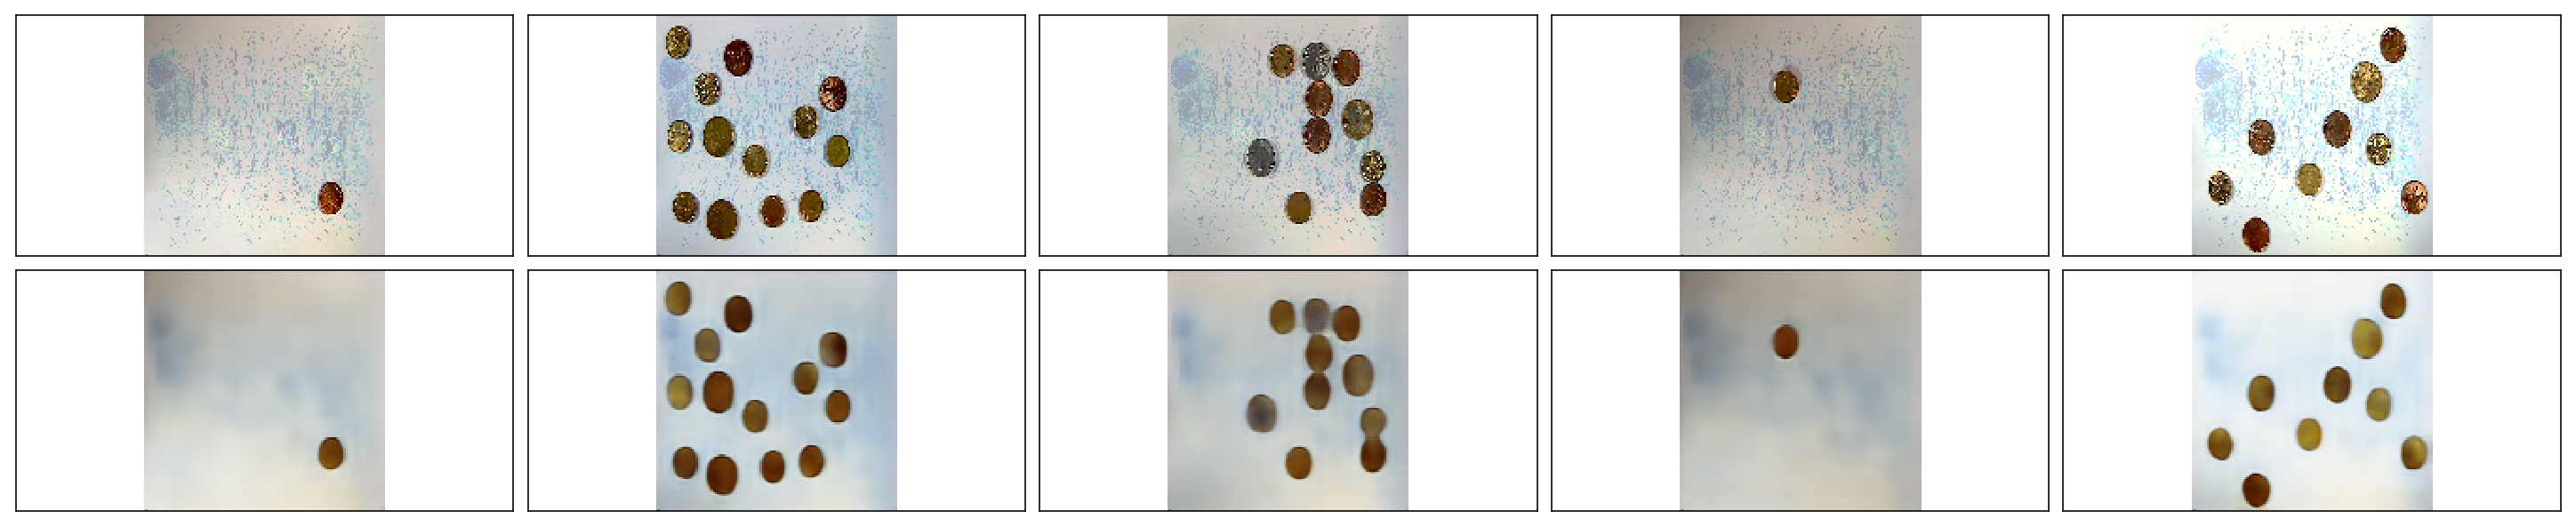

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20,4))
in_imgs = normalized_images[:5]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((128, 128, 3)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

As we can see, after resizing our images, we've got a lot of noise.

Our model could reproduce well those images with only 10 epochs of traning! It's awesome.

## Conclusion

As we could see before, an autoencoder can generate images easily encoding and decoding.

Autoencoders are the base of unsupervised learning and generative neural networks.

You can see more about autoenconders here:

[Stanford Autoencoder Tutorial](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
[Deep Learning Book](http://www.deeplearningbook.org/contents/autoencoders.html)
[Siraj's "How to Generate Images" video](https://www.youtube.com/watch?v=3-UDwk1U77s)
[Siraj's "How to Generate Images with Tensorflow"]